Link do Dataset: https://www.kaggle.com/code/paulorzp/laborat-rio-12b-usando-lstm-em-s-ries-temporais?select=international-airline-passengers.csv

### Instalação e importação das bibliotecas necessárias

In [1]:
!pip install tensorflow --upgrade
!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

### Carregar dados

In [ ]:

data_path = "international-airline-passengers.csv"
df = pd.read_csv(data_path, skiprows=1, names=["Month", "Passengers"], engine='python')
df = df[df["Month"] != "International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"]
df["Month"] = pd.to_datetime(df["Month"])
df["Passengers"] = df["Passengers"].astype(float)
df.set_index("Month", inplace=True)

### Transformação Logaritmica e separação entre treino e teste

In [ ]:
# Transformação logarítmica para estabilizar a variância
df["Passengers"] = np.log(df["Passengers"])

# Separação em treino e teste (80%-20%)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

### MODELO PROPHET

In [ ]:
prophet_df = df.reset_index()
prophet_df.columns = ['ds', 'y']
model_prophet = Prophet(changepoint_prior_scale=0.1) 
model_prophet.add_seasonality(name='yearly', period=12, fourier_order=10)
model_prophet.fit(prophet_df[:train_size])

future = model_prophet.make_future_dataframe(periods=len(test), freq='M')
forecast = model_prophet.predict(future)

# Reverter log para escala real
forecast_test = np.exp(forecast.iloc[train_size:]['yhat'].values)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8sls1bn_/mr0hth_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8sls1bn_/5xk9ffl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=519', 'data', 'file=/tmp/tmp8sls1bn_/mr0hth_i.json', 'init=/tmp/tmp8sls1bn_/5xk9ffl4.json', 'output', 'file=/tmp/tmp8sls1bn_/prophet_modelkl6f9j43/prophet_model-20250402111639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:39 - cmdstanpy - INFO - Chain [1] done

### MODELO LSTM

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df) 

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

### Tamanho da janela para a sazonalidade e ajuste de treino e teste para formato de sequências

In [ ]:
# Ajuste da janela para capturar a sazonalidade
window_size = 13
X, y = create_sequences(df_scaled, window_size)

# Separar em treino e teste no formato de sequências
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
y_train, y_test = y[:int(len(y)*0.8)], y[int(len(y)*0.8):]

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)), 
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epochs = 300
batch_size = 16

# shuffle=False para respeitar a ordem temporal
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=0,
    shuffle=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Previsões LSTM

In [ ]:
y_pred_lstm_scaled = model.predict(X_test)

# Volta do MinMaxScaler -> valores em log(Passengers)
y_pred_lstm_log = scaler.inverse_transform(y_pred_lstm_scaled)

# Aplica exp para voltar à escala real
y_pred_lstm = np.exp(y_pred_lstm_log)

# Ajuste de y_test para comparação na escala real
y_test_log = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_real = np.exp(y_test_log).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


### Cálculo das métricas

In [ ]:
# Prophet
test_real = np.exp(test['Passengers'].values)  # Reverter log para comparar
mae_prophet = mean_absolute_error(test_real, forecast_test)
rmse_prophet = sqrt(mean_squared_error(test_real, forecast_test))

# LSTM
n = min(len(y_test_real), len(y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_real[:n], y_pred_lstm[:n])
rmse_lstm = sqrt(mean_squared_error(y_test_real[:n], y_pred_lstm[:n]))

print(f'Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}')
print(f'LSTM    - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}')

Prophet - MAE: 78.69, RMSE: 87.52
LSTM    - MAE: 34.95, RMSE: 47.99


### Plotagem dos gráficos de comparação entre os modelos

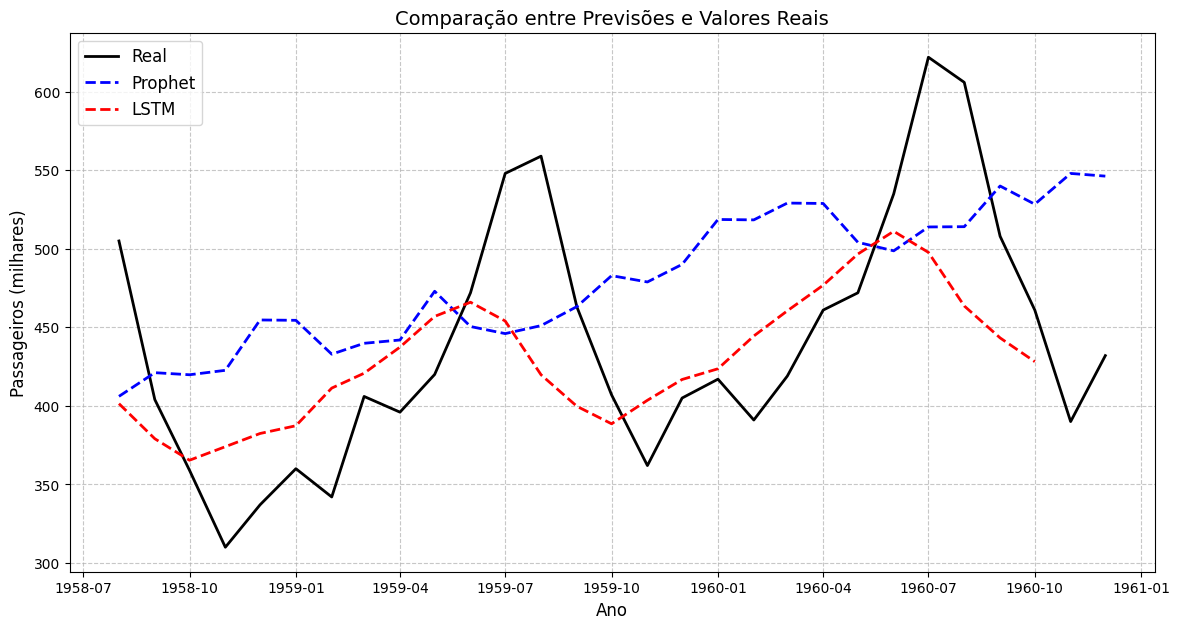

In [ ]:
plt.figure(figsize=(14,7))

# Curva real (escala real)
plt.plot(test.index, test_real, label='Real', color='black', linewidth=2)

# Previsão Prophet
plt.plot(test.index, forecast_test, label='Prophet', linestyle='dashed', color='blue', linewidth=2)

# Previsão LSTM (mesmo intervalo)
plt.plot(test.index[:n], y_pred_lstm[:n], label='LSTM', linestyle='dashed', color='red', linewidth=2)

plt.legend(loc='upper left', fontsize=12)
plt.title("Comparação entre Previsões e Valores Reais", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Passageiros (milhares)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

O modelo LSTM até teve um bom desempenho comparado com o prophet, capturando alguma sazonalidade. Ajustei para 13 meses para chegar nesse resultado. O modelo prophet, apesar de algumas tentativas de melhoria não está performando bem em relação à sazonalidade, mas capturou bem a tendência geral.